In [20]:
%matplotlib inline

import autograd.numpy.random as npr
import autograd.numpy as np
from autograd import grad
from autograd.extend import primitive, defvjp
from autograd.misc.optimizers import adam
import scipy.special.lambertw as lambertw_
import autograd.scipy.stats.norm as norm
import matplotlib.pyplot as plt

npr.seed(100)

In [21]:
def lambertw(x):
    if np.any(x < -1/np.e):
        return np.NaN
    else:
        return lambertw_(x,0).real
    
lambertw = primitive(lambertw)

defvjp(lambertw, 
#            lambda ans, x: lambda g: g * ans/(x*(1+ans)),
        lambda ans, x: lambda g:  g * 1./ (x + np.exp(ans)),
        None 
      )

In [22]:
# generate sample data
N = 1000
D = 100
K = 5

scale = 1.
skew = -0.05
theta_o = theta = npr.randn(N,K) 
beta_o = beta = npr.randn(D,K) #* np.array([0.1,0.5,1,2,2.5])

loc = np.matmul(theta, beta.T)
u = npr.randn(N,D)
# z = u * scale + loc
y = u * np.exp(skew * u) * scale + loc

In [23]:
def make_lambertw_routines(y):
    
    def skew_function(skew, limit = 0.2, scale = 0.5):
        return 0.2 * np.tanh(scale * skew)
#         return skew

    def unpack_params(params):
        theta = np.reshape(params[:(N*K)], [N, K])
        beta = np.reshape(params[(N*K):-1], [D, K])
        skew = skew_function(params[-1])
#         skew = fskew
        return theta, beta, skew
        
    def lambertw_logpdf(loc, log_scale, skew, t):
        scale = np.exp(log_scale)
        u = (y - loc)/scale
        if skew != 0: #and t > 2000:
            u_ = u*skew
            W = lambertw(u_)
            z = W/skew
            jacobian = 1./(u_+np.exp(W))
            return norm.logpdf(z) + np.log(np.abs(jacobian)) - log_scale
        else:
            return norm.logpdf(u) - log_scale
      
    def objective(params, t):
        theta, beta, skew = unpack_params(params)
        loc = np.matmul(theta, beta.T)
        return -np.sum(lambertw_logpdf(loc, np.log(1.), skew, t))
    return objective, lambertw_logpdf, unpack_params, skew_function

def callback(params, i, g):
    if not i%100: print(i, objective(params, 0), skew_function(params[-1]), np.sum(params[:-1]), end ='\r')

In [24]:
theta_n = npr.randn(N,K)
beta_n = npr.randn(D,K)
# theta_n = theta_o
# beta_n = beta_o
init_params = np.concatenate([theta_n.flatten(),beta_n.flatten(),np.array([0.0001])])
objective, lambertw_logpdf, unpack_params, skew_function = make_lambertw_routines(y)
gradient = grad(objective)
final_params = adam(gradient, init_params, step_size=0.1, num_iters=5000, callback = callback)
theta_f, beta_f, skew = unpack_params(final_params) 
# Inference ends here. 
print("\n")
print("Estimated skew:", skew, "; Original skew:", -0.05)

KeyboardInterrupt: 

In [6]:
theta_f, beta_f, skew = unpack_params(final_params)
# estimated parameters and likelihood 
loc = np.matmul(theta_f, beta_f.T)
print("Estimated parameters likelihood: ", np.sum(lambertw_logpdf(loc, np.log(1.), skew, 0)))
# original parameters and likelihood
loc = np.matmul(theta_o, beta_o.T)
print("Original parameters likelihood: ", np.sum(lambertw_logpdf(loc, np.log(1.), -0.05, 0)))

Estimated parameters likelihood:  -138523.719418
Original parameters likelihood:  -141332.292626


In [ ]:
loc = np.matmul(theta_o, beta_o.T)
x1 = (lambertw_logpdf(loc, np.log(1.0), -0.05, 0)).flatten()
loc = np.matmul(theta_f, beta_f.T)
y1 = (lambertw_logpdf(loc, np.log(1.0), skew, 0)).flatten()


plt.plot(x1, y1, 'x')
# plt.axis('equal')
plt.show()

array([ -2.00000000e-01,  -1.50000000e-01,  -1.00000000e-01,
        -5.00000000e-02,  -5.55111512e-17,   5.00000000e-02,
         1.00000000e-01,   1.50000000e-01])

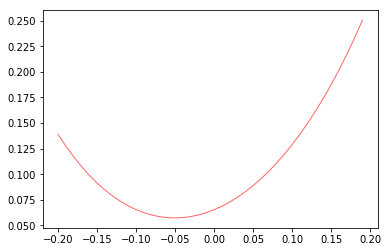

In [9]:
loc = np.matmul(theta_f, beta_f.T)
# z = u * scale + loc
skews = np.arange(-0.2, 0.2, 0.01)
mse = [np.mean((y - (u * np.exp(s * u) * scale + loc))**2) for s in skews]
plt.plot(skews, mse, 'r-', lw=1, alpha=0.6)
skews = np.arange(-0.2, 0.2, 0.05)

skews

In [ ]:
# theta, beta, skew = unpack_params(final_params)
# loc = np.matmul(theta_o, beta_o.T)
# -np.sum(lambertw_logpdf(loc, np.log(1.), -0.05, 2000)) 
# skews = np.arange(-1, 1, 0.01)
# pdf = np.copy(skews)

theta, beta, skew = unpack_params(final_params)
loc = np.matmul(theta, beta.T)

for i,s in enumerate(skews):
    pdf[i] = np.sum(lambertw_logpdf(loc, np.log(1.0), s, 5000))
plt.plot(skews, pdf, 'r-', lw=1, alpha=0.6)
# skews[np.where(pdf == np.max(pdf))]

theta, beta, skew = unpack_params(final_params)
loc = np.matmul(theta, beta.T)
np.mean(loc)

In [ ]:
# theta, beta, skew = unpack_params(final_params)
# loc = np.matmul(theta, beta.T)

objective(params, 0)

z_new = (u * np.exp(skew * u))
# plt.hist(z_new.flatten(), 100, normed=True, alpha=0.2)
# plt.hist(z.flatten(), 100, normed=True, alpha=0.2)
y_new = u * np.exp(skew * u) * scale + loc
# plt.show()
print(y_new[1,])
y[1,]

In [ ]:
def unpack_params(params):
    return params[0], params[1], params[2]

def lambertw_logpdf(y, loc, log_scale, skew):
    scale = np.exp(log_scale)
    u = (y - loc)/scale
    if skew != 0:
        u_ = u*skew
        W = lambertw(u_)
        z = W/skew
        jacobian = W/(u_*(1+W))
        return norm.logpdf(z) + np.log(np.abs(jacobian)) - log_scale
    else:
        return norm.logpdf(u) - log_scale

In [ ]:
# theta_o = theta = npr.randn(N,K) 
# beta_o = beta = npr.randn(D,K) 
# loc = np.matmul(theta, beta.T)
# skews = np.arange(-1, 1, 0.01)
# pdf = np.array([np.sum((lambertw_logpdf(y, loc, np.log(1.), skew))) for skew in skews])
# plt.plot(skews, pdf, 'r-', lw=1, alpha=0.6)
# skews[np.where(pdf == np.max(pdf))]

In [ ]:
def make_lambertw_routines(y):
    
    def skew_function(skew, limit = 0.2, scale = 1.):
#         return 0.15 * np.tanh(scale * skew)
        return skew
    
    def unpack_params(params):
        theta = np.reshape(params[:(N*K)], [N, K])
        beta = np.reshape(params[(N*K):-1], [D, K])
#         skew = skew_function(params[-1])
        skew = -0.1
        return theta, beta, skew
        
    def lambertw_logpdf(loc, log_scale, skew):
        scale = np.exp(log_scale)
        u = (y - loc)/scale
        if skew != 0:
            u_ = u*skew
            W = lambertw(u_)
            z = W/skew
            jacobian = W/(u_*(1+W))
            return gnorm.logpdf(z) + np.log(np.abs(jacobian)) - log_scale
        else:
            return gnorm.logpdf(u) - log_scale
      
    def objective(params, t):
        theta, beta, skew = unpack_params(params)
        loc = np.matmul(theta, beta.T)
        return -np.sum(lambertw_logpdf(loc, np.log(1.), skew))
    return objective, lambertw_logpdf, unpack_params, skew_function


def callback(params, i, g):
    if not i%100: print(i, objective(params, 0), skew_function(params[-1]), np.sum(params[:-1]), end ='\r')

In [ ]:
theta_n = npr.randn(N,K)
beta_n = npr.randn(D,K)
init_params = np.concatenate([theta_n.flatten(),beta_n.flatten(),np.array([-0.1])])
objective, lambertw_logpdf, unpack_params, skew_function = make_lambertw_routines(y)
gradient = grad(objective)
final_params = adam(gradient, init_params, step_size=0.1, num_iters=10000, callback = callback)
theta_f, beta_f, skew = unpack_params(final_params) 
skew

In [ ]:
def make_lambertw_routines(y):
    
    def unpack_params(params):
        theta = anp.reshape(params[:(N*K)], [N, K])
        beta = anp.reshape(params[(N*K):], [D, K])
        return theta, beta
        
    def lambertw_logpdf(theta, beta):
        loc = anp.matmul(theta, beta.T)
        return (gnorm.logpdf(y, loc , 1.))
    
    def objective(params, t):
        theta, beta = unpack_params(params)
        return -anp.sum(lambertw_logpdf(theta, beta))
    return objective, lambertw_logpdf, unpack_params


def callback(params, i, g):
    if not i%100: print(i, objective(params, 0), end ='\r')
    
theta_n = npr.randn(N,K)
beta_n = npr.randn(D,K)
init_params = np.concatenate([theta_n.flatten(),beta_n.flatten()])
objective, lambertw_logpdf, unpack_params = make_lambertw_routines(z)
gradient = grad(objective)
final_params = adam(gradient, init_params, step_size=0.1, num_iters=1000, callback = callback)
theta_f, beta_f = unpack_params(final_params) 

In [ ]:
z_new = np.matmul(theta_f, beta_f.T) + npr.randn(N,D)
plt.hist(z_1.flatten(), 100, normed=True, alpha=0.2)
plt.hist(z_new.flatten(), 100, normed=True, alpha=0.2)
loc = np.mean(z_new)
scale = np.std(z_new)
x = np.linspace(norm.ppf(0.001, loc, scale), norm.ppf(0.999, loc, scale), 100)
plt.plot(np.sort(z_new.flatten()), norm.pdf(np.sort(z_new.flatten()), loc, scale), 'r-', lw=1, alpha=0.6)
plt.show()

In [ ]:
theta_n = npr.randn(N,K)
beta_n = npr.randn(D,K)
init_params = np.concatenate([theta_n.flatten(),beta_n.flatten()])
objective, lambertw_logpdf, unpack_params = make_lambertw_routines(y)
gradient = grad(objective)
final_params = adam(gradient, init_params, step_size=0.1, num_iters=1000, callback = callback)
theta_f, beta_f = unpack_params(final_params) 

z_new = np.matmul(theta_f, beta_f.T) + npr.randn(N,D)
plt.hist(y.flatten(), 100, normed=True, alpha=0.2)
plt.hist(z_new.flatten(), 100, normed=True, alpha=0.2)
loc = np.mean(z_new)
scale = np.std(z_new)
x = np.linspace(norm.ppf(0.001, loc, scale), norm.ppf(0.999, loc, scale), 100)
plt.plot(np.sort(z_new.flatten()), norm.pdf(np.sort(z_new.flatten()), loc, scale), 'r-', lw=1, alpha=0.6)
plt.show()

In [ ]:
def make_lambertw_routines(y):
    def unpack_params(params):
#         theta = anp.reshape(params[:(N*K)], [N, K])
#         beta = anp.reshape(params[(N*K):-1], [D, K])
        skew = 0.2 * anp.tanh(params[-1])
#         skew = params[-1]
        return theta, beta, skew
        
    def lambertw_logpdf(loc, log_scale, skew):
        scale = anp.exp(log_scale)
        u = (y - loc)/scale
        if skew != 0:
            u_ = u*skew
            W = lambertw(u_)
            z = W/skew
            jacobian = W/(u_*(1+W))
            return gnorm.logpdf(z) + anp.log(anp.abs(jacobian)) - log_scale
        else:
            return gnorm.logpdf(u) - log_scale
      
    def objective(params, t):
        theta, beta, skew = unpack_params(params)
        loc = anp.matmul(theta, beta.T)
        return -anp.sum(lambertw_logpdf(loc, np.exp(1.), skew))
    return objective, lambertw_logpdf, unpack_params


def callback(params, i, g):
    if not i%100: print(i, objective(params, 0), 0.2*anp.tanh(params[-1]), end ='\r')
   

# theta_n = npr.randn(N,K)
# beta_n = npr.randn(D,K)

In [ ]:
init_params = np.concatenate([theta_n.flatten(),beta_n.flatten(),np.array([-0.1])])
objective, lambertw_logpdf, unpack_params = make_lambertw_routines(y)
gradient = grad(objective)
final_params = adam(gradient, init_params, step_size=0.1, num_iters=1000, callback = callback)
theta_f, beta_f, skew = unpack_params(final_params) 
skew

In [ ]:
loc = np.matmul(theta_f, beta_f.T)
scale = 1.
#y = u * np.exp(skew * u) * scale + loc

In [ ]:
0.2 * anp.tanh(skew)

In [ ]:
init_params[-1]

In [ ]:
k = np.arange(-10000,10, step = 1)
plt.plot(k, lambertw(k), 'r-', lw=1, alpha=0.6)

In [ ]:
np.min(0.05 * npr.randn(100000))

In [ ]:
from scipy.special import lambertw

import numpy as np

import matplotlib.pyplot as plt



def populate_lambertw(a, b, resolution):
    x = np.linspace(a, b, resolution * (b - a) + 1)
    y = dict(zip(x, lambertw(x,0).real))
    def lw(i):
        i = int((i - a) * resolution)
        return y[i]
    return lw


# xs = np.linspace(0.0, 1.0, 300)
memoized_lambertw = populate_lambertw(-5, 5, 100)
memoized_lambertw(5)
# plt.plot(xs, memoized_lambert(xs))
# plt.plot(xs, lambertw(xs).real)
# plt.show()
xs.shape

In [ ]:
lambertw_(-0.38, 1)

In [ ]:
dict('a')